In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [2]:
train=pd.read_csv('train.csv',sep='|')

In [3]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [4]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)

# Model factory

In [7]:
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


model_tuning_factory = [
    GridSearchCV(GradientBoostingClassifier(),
                 dict(),
                 #dict(n_estimators = range(1,150)),
                 #     learning_rate = np.arange(0.01, 1.0, 0.01)),
                 cv = skf,
                 scoring = my_custom_score)
]           
                 
                 
iterations = 10                 
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(GradientBoostingClassifier(),
                 dict(n_estimators = range(1,150),
                      learning_rate = np.arange(0.01, 1.0, 0.01)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),      
]

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)
loo = LeaveOneOut()

In [9]:
Y = train['fraud']
X = train.drop('fraud',axis=1)

In [12]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Time needed", "Raw Model"])


# three types of data preparation: No preparation, MaxMinScaler, StandardScaler
for data_preparation_step in range(1,5):
    if (data_preparation_step == 1):  
        X_scaled = X
        data_preparation = "No Scaling"
    elif (data_preparation_step == 2):
        feature_scaler = MinMaxScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
        data_preparation = "MinMaxScaler"
    elif (data_preparation_step == 3):
        feature_scaler = StandardScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
        data_preparation = "StandardScaler"
    elif (data_preparation_step == 4):
        transformer = FunctionTransformer(np.log1p, validate=True)  
        X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
        data_preparation = "LogScaler"      

    for feature_count in range(1,len(list(X))+1):

        for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results
            
            start_time = time.time()
            
            best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
            best_feature_list = X.columns[best_features.get_support()]
            X_selected_features = X[best_feature_list]
            
            model.seed = 42
            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]
            
            end_time = time.time()
            
            print("Finished " + model.best_estimator_.__class__.__name__ + " with " + data_preparation + " and " + str(feature_count) + " features after " + str(end_time - start_time) + " seconds")

            result_table = result_table.append({
             "Model": model_name,
             "Data Preparation": data_preparation,
             "Feature Count": feature_count,
             "Features": best_feature_list.values,
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,
             "Time needed": end_time - start_time,    
             "Raw Model": model.best_estimator_
              }, ignore_index=True)
    
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished GradientBoostingClassifier with No Scaling and 1 features after 0.3689768314361572 seconds
Finished GradientBoostingClassifier with No Scaling and 2 features after 0.536184549331665 seconds
Finished GradientBoostingClassifier with No Scaling and 3 features after 0.6418020725250244 seconds
Finished GradientBoostingClassifier with No Scaling and 4 features after 0.7222161293029785 seconds
Finished GradientBoostingClassifier with No Scaling and 5 features after 0.7576513290405273 seconds
Finished GradientBoostingClassifier with No Scaling and 6 features after 0.8282907009124756 seconds
Finished GradientBoostingClassifier with No Scaling and 7 features after 0.8966522216796875 seconds
Finished GradientBoostingClassifier with No Scaling and 8 features after 0.9348881244659424 seconds
Finished GradientBoostingClassifier with No Scaling and 9 features after 0.9731786251068115 seconds
Finished GradientBoostingClassifier with No Scaling and 10 features after 1.0577237606048584 seconds


,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Time needed,Raw Model
68,GradientBoostingClassifier,LogScaler,9,"[trustLevel, totalScanTimeInSeconds, valuePerS...",{},0.130389,0.104879,1.055202,([DecisionTreeRegressor(criterion='friedman_ms...
67,GradientBoostingClassifier,LogScaler,8,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.117084,0.121028,0.981055,([DecisionTreeRegressor(criterion='friedman_ms...
72,GradientBoostingClassifier,LogScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.111762,0.137173,1.314617,([DecisionTreeRegressor(criterion='friedman_ms...
29,GradientBoostingClassifier,MinMaxScaler,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.106440,0.134110,1.059558,([DecisionTreeRegressor(criterion='friedman_ms...
49,GradientBoostingClassifier,StandardScaler,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.106440,0.134110,1.057784,([DecisionTreeRegressor(criterion='friedman_ms...
9,GradientBoostingClassifier,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.106440,0.134110,1.057724,([DecisionTreeRegressor(criterion='friedman_ms...
70,GradientBoostingClassifier,LogScaler,11,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.106440,0.134110,1.127966,([DecisionTreeRegressor(criterion='friedman_ms...
71,GradientBoostingClassifier,LogScaler,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.093135,0.144889,1.217129,([DecisionTreeRegressor(criterion='friedman_ms...
73,GradientBoostingClassifier,LogScaler,14,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.090474,0.152513,1.388133,([DecisionTreeRegressor(criterion='friedman_ms...
76,GradientBoostingClassifier,LogScaler,17,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.085152,0.157366,1.596618,([DecisionTreeRegressor(criterion='friedman_ms...


In [13]:
result_table = result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)
result_table

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Time needed,Raw Model
68,GradientBoostingClassifier,LogScaler,9,"[trustLevel, totalScanTimeInSeconds, valuePerS...",{},0.130389,0.104879,1.055202,([DecisionTreeRegressor(criterion='friedman_ms...
67,GradientBoostingClassifier,LogScaler,8,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.117084,0.121028,0.981055,([DecisionTreeRegressor(criterion='friedman_ms...
72,GradientBoostingClassifier,LogScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.111762,0.137173,1.314617,([DecisionTreeRegressor(criterion='friedman_ms...
29,GradientBoostingClassifier,MinMaxScaler,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.106440,0.134110,1.059558,([DecisionTreeRegressor(criterion='friedman_ms...
49,GradientBoostingClassifier,StandardScaler,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.106440,0.134110,1.057784,([DecisionTreeRegressor(criterion='friedman_ms...
9,GradientBoostingClassifier,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.106440,0.134110,1.057724,([DecisionTreeRegressor(criterion='friedman_ms...
70,GradientBoostingClassifier,LogScaler,11,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.106440,0.134110,1.127966,([DecisionTreeRegressor(criterion='friedman_ms...
71,GradientBoostingClassifier,LogScaler,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.093135,0.144889,1.217129,([DecisionTreeRegressor(criterion='friedman_ms...
73,GradientBoostingClassifier,LogScaler,14,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.090474,0.152513,1.388133,([DecisionTreeRegressor(criterion='friedman_ms...
76,GradientBoostingClassifier,LogScaler,17,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.085152,0.157366,1.596618,([DecisionTreeRegressor(criterion='friedman_ms...


Text(0, 0.5, 'Monetary Value Per Instance - Mean')

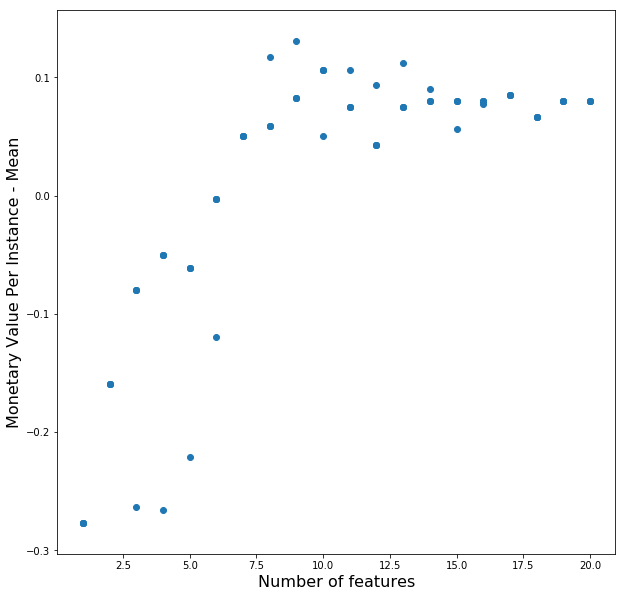

In [14]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table["Feature Count"], result_table["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [15]:
best_model = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Features"]

print(best_model)
print(best_model_features)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
['trustLevel' 'totalScanTimeInSeconds' 'valuePerSecond'
 'lineItemVoidsPerPosition' 'scannedLineItems' 'pricePerScannedLineItem'
 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem' 'secondsPerEuro']


In [31]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  1775
False positive:  0
False negative:  0
True positive:  104
520 for 1879 instances in the test set
0.2767429483767962 per instance in the test set
